In [1]:
import FinanceDataReader as fdr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def getCloseData(ticker, start, end=None):
    """
    종가 데이터
    ticker: 종목 번호
    start: 시작일
    end: 마지막 날짜
    return: 종목의 종가 데이터
    """
    return fdr.DataReader(ticker, start, end)['Close']

def getDayReturn(closeDataSet):
    """
    개별종목 일별 수익률
    closeDataSet: 종가 데이터
    return: 종가 데이터의 일별 수익률
    """
    return (closeDataSet / closeDataSet.shift(1)).fillna(1)

def getCumulativeReturn(closeDataSet):
    """
    개별종목 누적수익률 == 자산흐름
    closeDataSet: 종가 데이터
    return:종가데이터 누적수익률
    """
    return closeDataSet / closeDataSet.iloc[0]

def getPortfolioResult(closeDataSet, weight=None):
    """
    포트폴리오 결과
    closeDataSet: 종가 데이터
    weight: 포트폴리오 개별자산 비중
    return: 포트폴리오 일간수익률, 누적수익률
    """
    # 개별종목 일별 수익률
    dayReturn = getDayReturn(closeDataSet)
    # 개별종목 누적 수익률
    cumulativeReturn = getCumulativeReturn(closeDataSet)
    # 자산별 비중. 기본값: 동일비중
    if not weight:
        weight = [1/len(closeDataSet.columns)] * len(closeDataSet.columns)
        
    # 포트폴리오 누적 수익률
    portfolioCumulativeReturn = (weight * cumulativeReturn).sum(axis=1)
    # 포트폴리오 일별 수익률
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1)    
    return portfolioDayReturn, portfolioCumulativeReturn

def getEvaluation(cumulativeReturn):
    """
    cagr, dd, mdd
    투자 성과 지표
    """
    # cagr
    cagr = cumulativeReturn.iloc[-1] ** (252/len(cumulativeReturn))
    # mdd
    dd = (cumulativeReturn.cummax() - cumulativeReturn) / cumulativeReturn.cummax() * 100
    mdd= dd.max()
    
    print(f"최종 수익률: {cumulativeReturn.iloc[-1]}\ncagr: {cagr}\nmdd: {mdd}")

    return cagr, dd, mdd

def getRebalancingDate(closeDataSet, period="month"):
    """
    리밸런싱 일자 추출
    월별, 분기별, 연별
    """
    data = closeDataSet.copy()
    data = pd.DataFrame(data)
    data.index = pd.to_datetime(data.index)
    data['year'] = data.index.year
    data['month'] = data.index.month
    
    if period == "month":
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index
        
    if period == "quarter":
        # 3 6 9 12월 말에 리밸런싱
        # np where 같은걸로 3, 6, 9, 12월 데이터만 가져오고
        # drop_duplicates keep last 하면 됌
        quarter = [3,6,9,12]
        data = data.loc[data['month'].isin(quarter)]
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index
    
    if period == "year":
        rebalancingDate = data.drop_duplicates(['year'], keep="last").index
        
    return rebalancingDate

def getRebalancingPortfolioResult(closeDataSet, period = "month", weightDf=None):
    """
    리밸런싱 포트폴리오 결과
    closeDataSet: 종가 데이터
    weight: 포트폴리오 개별자산 비중
    return: 포트폴리오 일간수익률, 누적수익률
    """
    
    # 자산별 비중. 기본값: 동일비중
    if weightDf is None:
        rebalancingDate = getRebalancingDate(closeDataSet, period) # 리밸런싱 날짜
        weightDf = pd.DataFrame([[1/len(closeDataSet.columns)] * len(closeDataSet.columns)] * len(rebalancingDate),
                              index=rebalancingDate,
                              columns=closeDataSet.columns)
    # 자산별 비중이 있는 경우
    else:
        closeDataSet = closeDataSet.loc[weightDf.index[0]:]
        rebalancingDate = getRebalancingDate(closeDataSet, period) # 리밸런싱 날짜
      
    portfolio = pd.DataFrame() # 빈 데이터 프레임 생성

    totalAsset = 1 # 총 자산, 초기값 1
    start = rebalancingDate[0] # 리밸런싱 날짜, 초기값 첫 투자일

    for end in rebalancingDate[1:]:
        weight = weightDf.loc[start] # 당월 리밸런싱 비율
        priceData = closeDataSet.loc[start:end] # 당월 가격 데이터
        cumReturn = getCumulativeReturn(priceData) # 당월 누적 수익률
        weightedCumReturn = weight * cumReturn # 당월 리밸런싱 비율이 반영된 누적 수익률
        netCumReturn = totalAsset * weightedCumReturn # 전월 투자 결과 반영

        start = end # start 갱신
        totalAsset = netCumReturn.iloc[-1].sum() # 총 자산 갱신
        portfolio = pd.concat([portfolio, netCumReturn]) # 매월 데이터 추가
    
    portfolio = portfolio.loc[~portfolio.index.duplicated(keep='last')] # 중복 데이터 제거
    portfolioCumulativeReturn = portfolio.sum(axis=1) # 포트폴리오 누적 수익률
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1) # 포트폴리오 일간 수익률
    
    return portfolioDayReturn, portfolioCumulativeReturn

def getWeightByAvgMomentumScore(closeDataSet, n = 12):
    """
    평균 모멘텀 스코어를 기반으로 한 투자 비중 구하기
    closeDataSet: 종가 데이터
    n: 모멘텀 기간 1~n
    return: 투자비중 weight df, 평균모멘텀 스코어 df
    """
    avgMomentumScore = 0 # 평모스 초기값
    priceOnRebalDate = closeDataSet.loc[getRebalancingDate(closeDataSet)] # 리밸런싱 일자의 가격 데이터
    
    # 1 ~ n개월 모멘텀 스코어 합
    for i in range(1, n+1):
        avgMomentumScore = np.where(priceOnRebalDate / priceOnRebalDate.shift(i) > 1, 1, 0) + avgMomentumScore
        
    # 평모스 계산
    avgMomentumScore = pd.DataFrame(avgMomentumScore, index=priceOnRebalDate.index, columns=priceOnRebalDate.columns) # dataframe 형변환
    avgMomentumScore = avgMomentumScore / n
    
    # 모멘텀 스코어에 따른 weight 계산
    weight = avgMomentumScore.divide(avgMomentumScore.sum(axis=1), axis=0).fillna(0)
    # 투자 비중이 모두 0인 구간에서는 현금 보유
    weight['cash'] = np.where(weight.sum(axis=1) == 0, 1, 0)
    
    # 투자비중, 평모스 리턴
    return weight, avgMomentumScore

## 리밸런싱


#### 리밸런싱 개념  

우리가 지금까지 배운 방법은 Buy & Hold 전략입니다.  
결국 장기적인 관점에서 자산 가치는 우상향하게 되어있기 때문에 가격의 흔들림에 굴하지 않고 기다리는 전략이었습니다.  
아주 오랜시간 기다려야하고. 중간중간 큰 낙폭이 오면 그대로 맞아야 하는 단점이 있습니다.  
이번에 배워볼 기법은 리밸런싱 입니다.  
리밸런싱이란 주기적으로 자산간 비중을 조절하는 것입니다.  
리밸런싱을 하는 이유는, 중간중간 적당한 차익을 실현하기 위함입니다.  
조금 더 고급진 표현으로는 고평가 된 자산을 일부 매도해서 저평가 된 자산을 매수하기 위해서 입니다.  
이렇게 리밸런싱 통해 일종에 고점 매도와 저점 매수효과를 어느정도 누릴 수 있게 되는 것입니다.

In [2]:
dummyData =pd.DataFrame(
    {
        "stock": [10, 5] * 5,
        "bond": [5, 10] * 5,
    },
)
dummyData

stock  bond
0     10     5
1      5    10
2     10     5
3      5    10
4     10     5
5      5    10
6     10     5
7      5    10
8     10     5
9      5    10

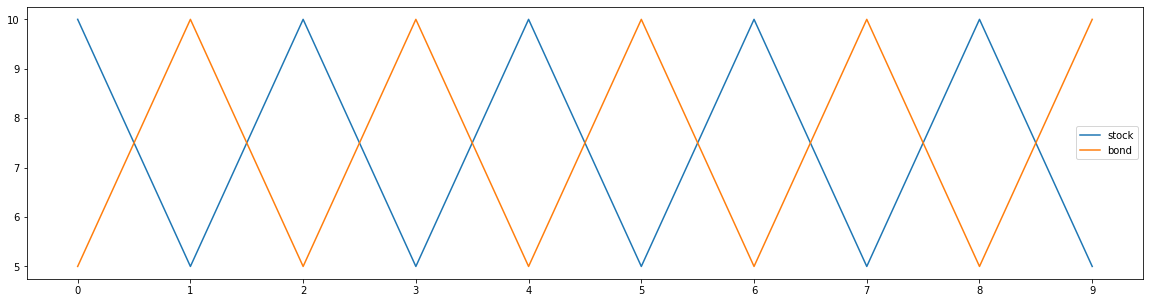

In [3]:
dummyData.plot(figsize=(20,5))
plt.xticks(dummyData.index)
plt.show()

0기에 20원이 있었고, 1:1로 채권과 주식을 매수했습니다. 그럼 평가액은 20~25을 반복하다가 결국 20이 됩니다.  
하지만 매번 1:1로 밸런스를 맞춘다 가정하고 다시 계산 해보도록 하겠습니다.  
그러면 매번 1.25배 늘어납니다. 이게 바로 리밸런싱 효과입니다.  
물론 이건 리밸런싱 효과를 잘 설명하기 위한 예시입니다.  
실제로는 가격 움직임이 저렇지 않아서 한쪽만 계속 오르고, 떨어진다면 리밸런싱 효과는 없겠죠.  
하지만 일반적으로 시장은 횡보와 추세를 계속 반복하기 때문에 리밸런싱 효과를 어느정도 누리는게 일반적으로 검증된 사실입니다.

지금까지는 사고 그대로 존버하는 포지션이었지만,  
이번엔 **매월 말 주식:현금 = 1:1 비율로 조절해주는 리밸런싱 기법**을 도입해보겠습니다.  

#### 리밸런싱 기법을 코드로 구현하기

In [4]:
# 더미데이터
closeDataSet = pd.DataFrame(
    {
        "kodex200": [100, 140, 120, 110, 100, 120, 110, 115, 120],
        "kodex10Bond": [100, 90, 105, 115, 125, 130, 120, 125, 130],
    },
    index=pd.to_datetime(["2022-01-31", "2022-02-10", "2022-02-21", "2022-02-28", "2022-03-10", "2022-03-19", "2022-03-31", "2022-04-20", "2022-04-30",])
)
closeDataSet

kodex200  kodex10Bond
2022-01-31       100          100
2022-02-10       140           90
2022-02-21       120          105
2022-02-28       110          115
2022-03-10       100          125
2022-03-19       120          130
2022-03-31       110          120
2022-04-20       115          125
2022-04-30       120          130

리밸런싱 날짜 계산

In [5]:
# 매달 마지막 영업일

copyCloseDataSet = closeDataSet.copy()

copyCloseDataSet['year'] = copyCloseDataSet.index.year
copyCloseDataSet['month'] = copyCloseDataSet.index.month

copyCloseDataSet

kodex200  kodex10Bond  year  month
2022-01-31       100          100  2022      1
2022-02-10       140           90  2022      2
2022-02-21       120          105  2022      2
2022-02-28       110          115  2022      2
2022-03-10       100          125  2022      3
2022-03-19       120          130  2022      3
2022-03-31       110          120  2022      3
2022-04-20       115          125  2022      4
2022-04-30       120          130  2022      4

In [6]:
rebalancingDate = copyCloseDataSet.drop_duplicates(['year','month'], keep="last").index
rebalancingDate

DatetimeIndex(['2022-01-31', '2022-02-28', '2022-03-31', '2022-04-30'], dtype='datetime64[ns]', freq=None)

리밸런싱 비중 계산

In [7]:
# 원하는 비중으로 넣어도 되지만, 우선 동일비중으로 가정
defaultWeight = [1/len(closeDataSet.columns)] * len(closeDataSet.columns) # [1/n, 1/n ~~~]
defaultWeight

[0.5, 0.5]

In [8]:
monthlyWeight = pd.DataFrame([defaultWeight] * len(rebalancingDate), index=rebalancingDate, columns=closeDataSet.columns)  # df 변환
monthlyWeight

kodex200  kodex10Bond
2022-01-31       0.5          0.5
2022-02-28       0.5          0.5
2022-03-31       0.5          0.5
2022-04-30       0.5          0.5

**(월별 리밸런싱 비중 * 누적 수익률) 구하기**

In [9]:
start = rebalancingDate[0] # 리밸런싱 날짜, 초기값 첫 투자일

for end in rebalancingDate[1:]:
    weight = monthlyWeight.loc[start] # 당월 리밸런싱 비율
    priceData = closeDataSet.loc[start:end] # 당월 가격 데이터
    cumReturn = getCumulativeReturn(priceData) # 당월 누적 수익률
    weightedCumReturn = weight * cumReturn # 당월 리밸런싱 비율이 반영된 누적 수익률
    
    start = end # start 갱신
    print(weightedCumReturn)

            kodex200  kodex10Bond
2022-01-31      0.50        0.500
2022-02-10      0.70        0.450
2022-02-21      0.60        0.525
2022-02-28      0.55        0.575
            kodex200  kodex10Bond
2022-02-28  0.500000     0.500000
2022-03-10  0.454545     0.543478
2022-03-19  0.545455     0.565217
2022-03-31  0.500000     0.521739
            kodex200  kodex10Bond
2022-03-31  0.500000     0.500000
2022-04-20  0.522727     0.520833
2022-04-30  0.545455     0.541667


**월별 투자 결과가 그 다음달에도 연속적으로 반영되어야 합니다.**

In [10]:
# 투자 결과 연속 반영

totalAsset = 1 # 총 자산, 초기값 1
start = rebalancingDate[0] # 리밸런싱 날짜, 초기값 첫 투자일

for end in rebalancingDate[1:]:
    weight = monthlyWeight.loc[start] # 당월 리밸런싱 비율
    priceData = closeDataSet.loc[start:end] # 당월 가격 데이터
    cumReturn = getCumulativeReturn(priceData) # 당월 누적 수익률
    weightedCumReturn = weight * cumReturn # 당월 리밸런싱 비율이 반영된 누적 수익률
    
    
    netCumReturn = totalAsset * weightedCumReturn # 전월 투자 결과 반영
    
    
    start = end # start 갱신
    
    print("갱신 전 총 자산: ",totalAsset)
    totalAsset = netCumReturn.iloc[-1].sum() # 총 자산 갱신
    print(netCumReturn)
    print("갱신 후 총 자산: ",totalAsset)

갱신 전 총 자산:  1
            kodex200  kodex10Bond
2022-01-31      0.50        0.500
2022-02-10      0.70        0.450
2022-02-21      0.60        0.525
2022-02-28      0.55        0.575
갱신 후 총 자산:  1.125
갱신 전 총 자산:  1.125
            kodex200  kodex10Bond
2022-02-28  0.562500     0.562500
2022-03-10  0.511364     0.611413
2022-03-19  0.613636     0.635870
2022-03-31  0.562500     0.586957
갱신 후 총 자산:  1.1494565217391304
갱신 전 총 자산:  1.1494565217391304
            kodex200  kodex10Bond
2022-03-31  0.574728     0.574728
2022-04-20  0.600852     0.598675
2022-04-30  0.626976     0.622622
갱신 후 총 자산:  1.2495985671936758


**위 결과를 하나의 데이터 프레임으로 합쳐서 전체 포트폴리오의 누적 수익률을 계산 할 수 있습니다.**

In [11]:
# 하나의 데이터 프레임으로 합치기

portfolio = pd.DataFrame() # 빈 데이터 프레임 생성

totalAsset = 1 # 총 자산, 초기값 1
start = rebalancingDate[0] # 리밸런싱 날짜, 초기값 첫 투자일

for end in rebalancingDate[1:]:
    weight = monthlyWeight.loc[start] # 당월 리밸런싱 비율
    priceData = closeDataSet.loc[start:end] # 당월 가격 데이터
    cumReturn = getCumulativeReturn(priceData) # 당월 누적 수익률
    weightedCumReturn = weight * cumReturn # 당월 리밸런싱 비율이 반영된 누적 수익률
    netCumReturn = totalAsset * weightedCumReturn # 전월 투자 결과 반영
    
    
    start = end # start 갱신
    totalAsset = netCumReturn.iloc[-1].sum() # 총 자산 갱신
    portfolio = pd.concat([portfolio, netCumReturn]) # 매월 데이터 추가

portfolio    

kodex200  kodex10Bond
2022-01-31  0.500000     0.500000
2022-02-10  0.700000     0.450000
2022-02-21  0.600000     0.525000
2022-02-28  0.550000     0.575000
2022-02-28  0.562500     0.562500
2022-03-10  0.511364     0.611413
2022-03-19  0.613636     0.635870
2022-03-31  0.562500     0.586957
2022-03-31  0.574728     0.574728
2022-04-20  0.600852     0.598675
2022-04-30  0.626976     0.622622

**매달 중복되는 데이터를 제거하고, 최종 포트폴리오 누적 수익률을 계산합니다.**

In [12]:
portfolio.index.duplicated(keep='last')

array([False, False, False,  True, False, False, False,  True, False,
       False, False])

In [13]:
portfolio.loc[~portfolio.index.duplicated(keep='last')]

kodex200  kodex10Bond
2022-01-31  0.500000     0.500000
2022-02-10  0.700000     0.450000
2022-02-21  0.600000     0.525000
2022-02-28  0.562500     0.562500
2022-03-10  0.511364     0.611413
2022-03-19  0.613636     0.635870
2022-03-31  0.574728     0.574728
2022-04-20  0.600852     0.598675
2022-04-30  0.626976     0.622622

In [14]:
portfolio = portfolio.loc[~portfolio.index.duplicated(keep='last')]

In [15]:
portCumReturn = portfolio.sum(axis=1)
portCumReturn

2022-01-31    1.000000
2022-02-10    1.150000
2022-02-21    1.125000
2022-02-28    1.125000
2022-03-10    1.122777
2022-03-19    1.249506
2022-03-31    1.149457
2022-04-20    1.199528
2022-04-30    1.249599
dtype: float64

#### 리밸런싱 일자 조회, 리밸런싱 포트폴리오 결과 계산 함수화

In [16]:
def getRebalancingDate(closeDataSet, period="month"):
    """
    리밸런싱 일자 추출
    월별, 분기별, 연별
    """
    data = closeDataSet.copy()
    data = pd.DataFrame(data) # 시리즈형 데이터가 들어오더라도 리밸런싱 날짜를 계산하기 위해서는 dataframe으로 변환 해야 함
    data.index = pd.to_datetime(data.index)
    data['year'] = data.index.year
    data['month'] = data.index.month
    
    # 월말 리밸런싱
    if period == "month":
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index
        
    # 분기말 리밸런싱
    if period == "quarter":
        # 3 6 9 12월 말에 리밸런싱
        # np where 같은걸로 3, 6, 9, 12월 데이터만 가져오고
        # drop_duplicates keep last
        quarter = [3,6,9,12]
        data = data.loc[data['month'].isin(quarter)]
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index
    
    # 연말 리밸런싱
    if period == "year":
        rebalancingDate = data.drop_duplicates(['year'], keep="last").index
        
    return rebalancingDate

In [ ]:
def getRebalancingPortfolioResult(closeDataSet, period = "month", weightDf=None):
    """
    리밸런싱 포트폴리오 결과
    closeDataSet: 종가 데이터
    weight: 포트폴리오 개별자산 비중
    return: 포트폴리오 일간수익률, 누적수익률
    """
    
    # 자산별 비중. 기본값: 동일비중
    if weightDf is None:
        rebalancingDate = getRebalancingDate(closeDataSet, period) # 리밸런싱 날짜
        weightDf = pd.DataFrame([[1/len(closeDataSet.columns)] * len(closeDataSet.columns)] * len(rebalancingDate),
                              index=rebalancingDate,
                              columns=closeDataSet.columns)
    # 자산별 비중이 있는 경우
    else:
        closeDataSet = closeDataSet.loc[weightDf.index[0]:]
        rebalancingDate = getRebalancingDate(closeDataSet, period) # 리밸런싱 날짜
      
    portfolio = pd.DataFrame() # 빈 데이터 프레임 생성

    totalAsset = 1 # 총 자산, 초기값 1
    start = rebalancingDate[0] # 리밸런싱 날짜, 초기값 첫 투자일

    for end in rebalancingDate[1:]:
        weight = weightDf.loc[start] # 당월 리밸런싱 비율
        priceData = closeDataSet.loc[start:end] # 당월 가격 데이터
        cumReturn = getCumulativeReturn(priceData) # 당월 누적 수익률
        weightedCumReturn = weight * cumReturn # 당월 리밸런싱 비율이 반영된 누적 수익률
        netCumReturn = totalAsset * weightedCumReturn # 전월 투자 결과 반영

        start = end # start 갱신
        totalAsset = netCumReturn.iloc[-1].sum() # 총 자산 갱신
        portfolio = pd.concat([portfolio, netCumReturn]) # 매월 데이터 추가
    
    portfolio = portfolio.loc[~portfolio.index.duplicated(keep='last')] # 중복 데이터 제거
    portfolioCumulativeReturn = portfolio.sum(axis=1) # 포트폴리오 누적 수익률
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1) # 포트폴리오 일간 수익률
    
    return portfolioDayReturn, portfolioCumulativeReturn

#### 실전 데이터 적용

In [17]:
# 데이터 로드
stockETF = getCloseData("SPY", "2002", "2022-6-17") # 주식 ETF
bondETF = getCloseData("IEF", "2002", "2022-6-17") # 채권 ETF

# kodex200 = 069500
# kodex10Bond = 152380
# S&P500 = SPY
# 미국 7-10 국채 = IEF

closeDataSet = pd.concat([stockETF, bondETF], axis=1)
closeDataSet.columns = ['stockETF', 'bondETF']
closeDataSet.dropna(inplace=True)
closeDataSet

stockETF  bondETF
Date                         
2015-07-07    208.02   105.69
2015-07-08    204.53   106.11
2015-07-09    204.90   105.37
2015-07-10    207.48   104.64
2015-07-13    209.77   104.36
...              ...      ...
2022-06-13    375.00    98.94
2022-06-14    373.87    98.15
2022-06-15    379.20    99.52
2022-06-16    366.65   100.17
2022-06-17    365.86   100.20

[1752 rows x 2 columns]

In [18]:
rebalancingDate = getRebalancingDate(closeDataSet)
rebalancingDate

DatetimeIndex(['2015-07-31', '2015-08-31', '2015-09-30', '2015-10-30',
               '2015-11-30', '2015-12-31', '2016-01-29', '2016-02-29',
               '2016-03-31', '2016-04-29', '2016-05-31', '2016-06-30',
               '2016-07-29', '2016-08-31', '2016-09-30', '2016-10-31',
               '2016-11-30', '2016-12-30', '2017-01-31', '2017-02-28',
               '2017-03-31', '2017-04-28', '2017-05-31', '2017-06-30',
               '2017-07-31', '2017-08-31', '2017-09-29', '2017-10-31',
               '2017-11-30', '2017-12-29', '2018-01-31', '2018-02-28',
               '2018-03-29', '2018-04-30', '2018-05-31', '2018-06-29',
               '2018-07-31', '2018-08-31', '2018-09-28', '2018-10-31',
               '2018-11-30', '2018-12-31', '2019-01-31', '2019-02-28',
               '2019-03-29', '2019-04-30', '2019-05-31', '2019-06-28',
               '2019-07-31', '2019-08-30', '2019-09-30', '2019-10-31',
               '2019-11-29', '2019-12-31', '2020-01-31', '2020-02-28',
      

리밸런싱 포트폴리오 결과 계산

In [19]:
rebalPortfolioDayReturn, rebalPortfolioCumulativeReturn = getRebalancingPortfolioResult(closeDataSet)

주식 채권 1:1 B&H 전략 결과 계산

In [20]:
portfolioDayReturn, portfolioCumulativeReturn = getPortfolioResult(closeDataSet.loc[rebalancingDate[0]:])

주식 100% B&H 전략 결과 계산

In [21]:
stockDayReturn = getDayReturn(stockETF.loc[rebalancingDate[0]:])
stockCumReturn = getCumulativeReturn(stockETF.loc[rebalancingDate[0]:])

#### 전략 성과 비교

In [22]:
print("리밸런싱 포트폴리오 누적 수익률")
print(rebalPortfolioCumulativeReturn.iloc[-1])
rebalCagr, rebalDD, rebalMDD = getEvaluation(rebalPortfolioCumulativeReturn)

리밸런싱 포트폴리오 누적 수익률
1.3144336813922362
최종 수익률: 1.3144336813922362
cagr: 1.040533675653413
mdd: 18.23841592487511


In [23]:
print("Buy & Hold 포트폴리오 누적 수익률")
print(portfolioCumulativeReturn.iloc[-1])
cagr, dd, mdd = getEvaluation(portfolioCumulativeReturn)

Buy & Hold 포트폴리오 누적 수익률
1.3397138396527302
최종 수익률: 1.3397138396527302
cagr: 1.0434184162429645
mdd: 20.042658378917032


In [24]:
print("주식 100% 포트폴리오 누적 수익률")
print(stockCumReturn.iloc[-1])
stockCagr, stockDd, stockMdd = getEvaluation(stockCumReturn)

주식 100% 포트폴리오 누적 수익률
1.7380522565320666
최종 수익률: 1.7380522565320666
cagr: 1.083647475840882
mdd: 34.10474670449843


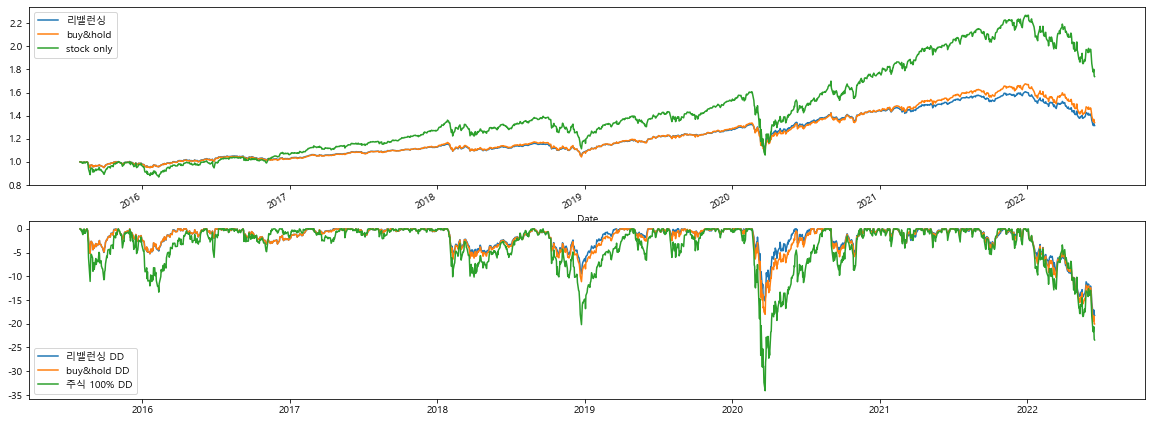

In [25]:
plt.rc('font', family='malgun gothic')
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(20,8))

# 수익곡선
plt.subplot(2,1,1)
rebalPortfolioCumulativeReturn.plot(label="리밸런싱")
portfolioCumulativeReturn.plot(label="buy&hold")
stockCumReturn.plot(label="stock only")
plt.legend()

# dd 곡선
plt.subplot(2,1,2)
plt.plot(-rebalDD, label="리밸런싱 DD")
plt.plot(-dd, label="buy&hold DD")
plt.plot(-stockDd, label="주식 100% DD")
plt.legend()

plt.show()